In [2]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore")

In [3]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_eff8b890fc014dd095e4207eb2ade298 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='gqDWXPmbM5kvnJ6Rfu7y56Jyz09hq2kcHraHDOgqYe_v',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_eff8b890fc014dd095e4207eb2ade298.get_object(Bucket='applieddsampaisession4-donotdelete-pr-zehrv0ociijt7k',Key='census.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [5]:
# Total Number of records
n_records = len(df)

# Number of records income >50K
n_greater_50k = len(df[df['income']=='>50K'])
# Number of records income <50K
n_less_50k = len(df[df['income']=='<=50K'])

# percentage of individuals where income is >50K
greater_percent = round(n_greater_50k/n_records*100)

# 
print('Total records: {}'.format(n_records))
print('Individuals making >50K: {}'.format(n_greater_50k))
print('Individuals making <=50K: {}'.format(n_less_50k))
print('Percent of individuals >50K: {}%'.format(greater_percent))

Total records: 45222
Individuals making >50K: 11208
Individuals making <=50K: 34014
Percent of individuals >50K: 25%


## Data preprocessing

### Transforming Skewed Features

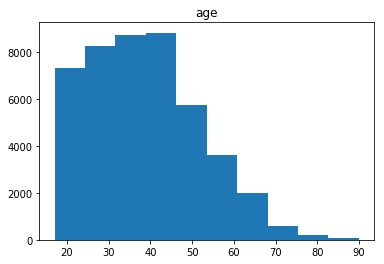

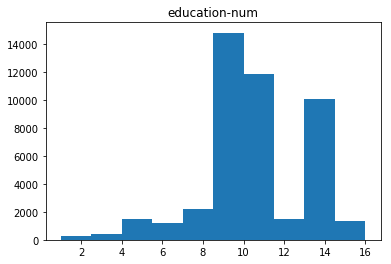

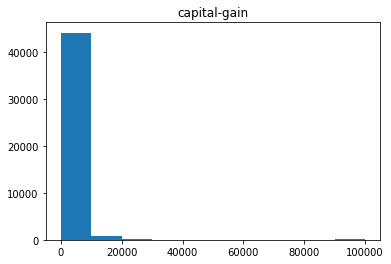

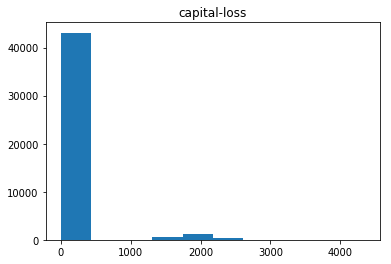

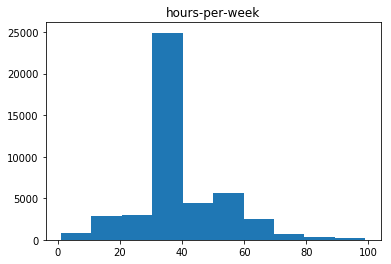

In [6]:
num_feature = df.columns[df.dtypes!='object']

def my_plot(feature):
    plt.hist(df[feature])
    plt.title(feature)
    plt.show()
    
for i in num_feature:
    my_plot(i)

In [7]:
df['capital-gain'] = np.log((df['capital-gain']+1))
df['capital-loss'] = np.log((df['capital-loss']+1))

In [8]:
df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,7.684784,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,40.0,Cuba,<=50K


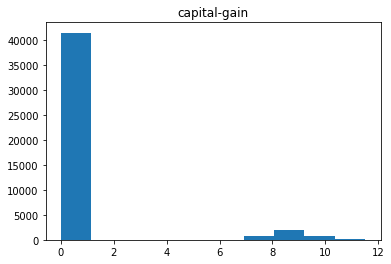

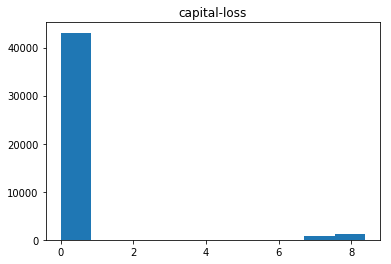

In [9]:
for i in ['capital-gain', 'capital-loss']:
    my_plot(i)

### One-hot Encoding

In [10]:
# encode 'income' column to numerical values
df['income'].replace({'<=50K':0, '>50K':1}, inplace=True)
df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,7.684784,0.0,40.0,United-States,0
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,13.0,United-States,0
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,40.0,United-States,0
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,40.0,United-States,0
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,40.0,Cuba,0


In [11]:
#One-hot encode all categorical features
df_cat_transformed = pd.get_dummies(df, drop_first=True)

print("{} total features after onehot encoding.".format(len(df_cat_transformed.columns)))
print(df_cat_transformed.columns)

96 total features after onehot encoding.
Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income', 'workclass_ Local-gov',
       'workclass_ Private', 'workclass_ Self-emp-inc',
       'workclass_ Self-emp-not-inc', 'workclass_ State-gov',
       'workclass_ Without-pay', 'education_level_ 11th',
       'education_level_ 12th', 'education_level_ 1st-4th',
       'education_level_ 5th-6th', 'education_level_ 7th-8th',
       'education_level_ 9th', 'education_level_ Assoc-acdm',
       'education_level_ Assoc-voc', 'education_level_ Bachelors',
       'education_level_ Doctorate', 'education_level_ HS-grad',
       'education_level_ Masters', 'education_level_ Preschool',
       'education_level_ Prof-school', 'education_level_ Some-college',
       'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
 

In [12]:
print(df_cat_transformed.columns[27])

marital-status_ Married-AF-spouse


### Shuffle and Split Data

In [13]:
# split features and target label
X = df_cat_transformed.drop('income', axis=1)
y = df_cat_transformed['income']

In [14]:
# split features and target into train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

### Normalizing Numerical Featrures

In [15]:
# scaling features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
X_train_scaled

array([[0.4109589 , 0.6       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.43835616, 0.53333333, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.05479452, 0.66666667, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.56164384, 0.8       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.53424658, 0.53333333, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.23287671, 0.53333333, 0.70438445, ..., 1.        , 0.        ,
        0.        ]])

In [17]:
# drop=True drops old index
y_train_scaled = y_train.reset_index(drop=True)
y_train_scaled 

0        0
1        0
2        0
3        1
4        0
5        0
6        0
7        0
8        0
9        1
10       0
11       1
12       0
13       1
14       0
15       0
16       0
17       0
18       1
19       0
20       1
21       0
22       1
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
36147    1
36148    1
36149    1
36150    0
36151    1
36152    1
36153    1
36154    0
36155    1
36156    0
36157    0
36158    0
36159    0
36160    0
36161    1
36162    1
36163    1
36164    0
36165    1
36166    0
36167    1
36168    0
36169    0
36170    1
36171    0
36172    0
36173    1
36174    1
36175    0
36176    0
Name: income, Length: 36177, dtype: int64

In [18]:
y_test_scaled = y_test.reset_index(drop=True)
y_test_scaled

0       0
1       0
2       0
3       0
4       0
5       1
6       0
7       1
8       0
9       0
10      0
11      0
12      0
13      1
14      0
15      0
16      0
17      0
18      1
19      1
20      0
21      1
22      0
23      0
24      0
25      0
26      1
27      0
28      0
29      0
       ..
9015    0
9016    0
9017    1
9018    1
9019    0
9020    0
9021    0
9022    0
9023    1
9024    0
9025    0
9026    1
9027    0
9028    0
9029    0
9030    0
9031    0
9032    1
9033    0
9034    0
9035    1
9036    0
9037    0
9038    0
9039    0
9040    0
9041    0
9042    0
9043    0
9044    1
Name: income, Length: 9045, dtype: int64

## Models and Perfomance Evaluation

### Initial Model Evaluation

In [19]:
# classifier pipeline
def train_predict(classifier):
    '''
    inputs: 
        - classifer: the learning algothim to be trained and perdicted on
    '''
    results = {}  # 'll be used to return metrics
    
    # train
    start_time = time()
    classifier = classifier.fit(X_train_scaled, y_train_scaled)
    end_time = time()
    results['train_time'] = round((end_time - start_time), 2)
    
    # perdict train/test labels
    start_time = time()
    y_pred_train = classifier.predict(X_train_scaled)
    y_pred_test = classifier.predict(X_test_scaled)
    end_time = time()
    results['pred_time'] = round((end_time - start_time), 2)
    
    # model evaluation (train/test) accuracy
    results['acc_train'] = round((accuracy_score(y_train_scaled, y_pred_train)), 2)
    results['acc_test'] = round((accuracy_score(y_test_scaled, y_pred_test)), 2)
    
    # model evaluation (train/test) f1_score
    results['f1_train'] = round((f1_score(y_train_scaled, y_pred_train)), 2)
    results['f1_test'] = round((f1_score(y_test_scaled, y_pred_test)), 2)
    
    report = classification_report(y_test_scaled, y_pred_test)
    
    return results, report

In [20]:
# initial model evaluation
clf_DT = DecisionTreeClassifier(random_state=0)
clf_LR = LogisticRegression(random_state=0)
clf_SVM = SVC(random_state=0)
clf_KNN = KNeighborsClassifier()
clf_NB = MultinomialNB()

clf_list = [clf_DT, clf_LR, clf_SVM, clf_KNN, clf_NB]

clf_evaluation = {}
clf_report = {}

for clf in clf_list:
    clf_evaluation[clf.__class__.__name__] = train_predict(clf)[0]
    clf_report[clf.__class__.__name__] = train_predict(clf)[1]

In [21]:
clf_evaluation

{'DecisionTreeClassifier': {'train_time': 0.31,
  'pred_time': 0.02,
  'acc_train': 0.97,
  'acc_test': 0.82,
  'f1_train': 0.94,
  'f1_test': 0.62},
 'LogisticRegression': {'train_time': 0.24,
  'pred_time': 0.01,
  'acc_train': 0.84,
  'acc_test': 0.84,
  'f1_train': 0.65,
  'f1_test': 0.65},
 'SVC': {'train_time': 104.21,
  'pred_time': 85.77,
  'acc_train': 0.84,
  'acc_test': 0.84,
  'f1_train': 0.63,
  'f1_test': 0.63},
 'KNeighborsClassifier': {'train_time': 3.15,
  'pred_time': 90.44,
  'acc_train': 0.87,
  'acc_test': 0.82,
  'f1_train': 0.73,
  'f1_test': 0.62},
 'MultinomialNB': {'train_time': 0.01,
  'pred_time': 0.01,
  'acc_train': 0.82,
  'acc_test': 0.82,
  'f1_train': 0.65,
  'f1_test': 0.64}}

In [22]:
print(clf_report['DecisionTreeClassifier'])

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6840
           1       0.63      0.62      0.62      2205

   micro avg       0.82      0.82      0.82      9045
   macro avg       0.75      0.75      0.75      9045
weighted avg       0.82      0.82      0.82      9045



In [23]:
print(clf_report['LogisticRegression'])

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6840
           1       0.71      0.60      0.65      2205

   micro avg       0.84      0.84      0.84      9045
   macro avg       0.79      0.76      0.77      9045
weighted avg       0.84      0.84      0.84      9045



In [24]:
print(clf_report['SVC'])

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6840
           1       0.71      0.56      0.63      2205

   micro avg       0.84      0.84      0.84      9045
   macro avg       0.79      0.74      0.76      9045
weighted avg       0.83      0.84      0.83      9045



In [25]:
print(clf_report['KNeighborsClassifier'])

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      6840
           1       0.65      0.59      0.62      2205

   micro avg       0.82      0.82      0.82      9045
   macro avg       0.76      0.74      0.75      9045
weighted avg       0.82      0.82      0.82      9045



In [26]:
print(clf_report['MultinomialNB'])

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      6840
           1       0.63      0.65      0.64      2205

   micro avg       0.82      0.82      0.82      9045
   macro avg       0.76      0.76      0.76      9045
weighted avg       0.82      0.82      0.82      9045



#### Results:

|     Metric     |         DT        |        LR       |      SVM      |        KNN      |  MultinomialNB  |
| :------------: | :---------------: | :-------------: |:------------: | :-------------: | :-------------: | 
| Train Accuracy |      **0.97**     |       0.84      |      0.84     |       0.87      |       0.82      |
| Test Accuracy  |        0.82       |     **0.84**    |    **0.84**   |       0.82      |       0.82      |
|                |                   |                 |               |                 |                 | 
| Train F1-Score |      **0.94**     |       0.65      |      0.63     |       0.73      |       0.65      |
| Test F1-Score  |        0.62       |     **0.65**    |      0.63     |       0.62      |       0.64      |  

  
- K-Nearest Neighbors has a high prediction time, which would be a problem in real-time classification
- MultinomialNB was used rather than GaussianNB, since most of the features are one-hot encoded (not real-valued features)


In [27]:
# classifiers names
classifiers = [clf.__class__.__name__ for clf in clf_list]

In [28]:
def eval_plot(xlabels, ylabel, title):
    
    # bars
    clf1 = [clf_evaluation[classifiers[0]][xlabels[0]], clf_evaluation[classifiers[0]][xlabels[1]]]
    clf2 = [clf_evaluation[classifiers[1]][xlabels[0]], clf_evaluation[classifiers[1]][xlabels[1]]]
    clf3 = [clf_evaluation[classifiers[2]][xlabels[0]], clf_evaluation[classifiers[2]][xlabels[1]]]
    clf4 = [clf_evaluation[classifiers[3]][xlabels[0]], clf_evaluation[classifiers[3]][xlabels[1]]]
    clf5 = [clf_evaluation[classifiers[4]][xlabels[0]], clf_evaluation[classifiers[4]][xlabels[1]]]
    
    x = np.arange(len(xlabels))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x-width/2, clf1, width, label=classifiers[0])
    ax.bar(x+width/2, clf2, width,label=classifiers[1])
    ax.bar(x+width*3/2, clf3, width,label=classifiers[2])
    ax.bar(x+width*5/2, clf4, width, label=classifiers[3])
    ax.bar(x+width*7/2, clf5, width,  label=classifiers[4])

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x+width*3/2)
    ax.set_xticklabels(xlabels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    for i in ax.patches:
        ax.text(i.get_x()+(width/2), i.get_height()+.02,
                str(i.get_height()), fontsize=10, ha='center')
            

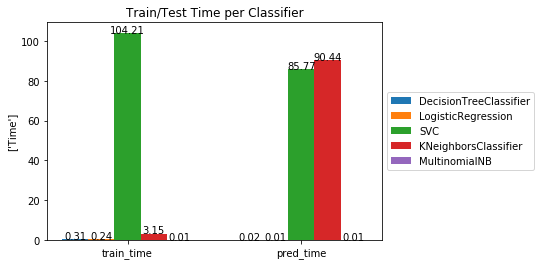

In [29]:
xlabels = ['train_time', 'pred_time'] 
ylabel = ['Time']
title = 'Train/Test Time per Classifier'
eval_plot(xlabels, ylabel, title)

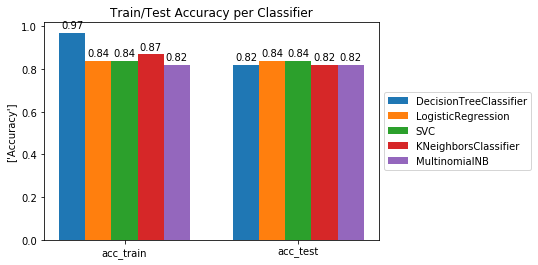

In [30]:
xlabels = ['acc_train', 'acc_test'] 
ylabel = ['Accuracy']
title = 'Train/Test Accuracy per Classifier'
eval_plot(xlabels, ylabel, title)

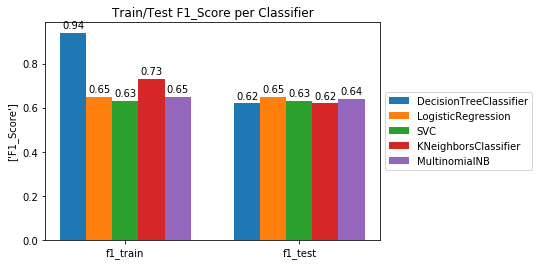

In [31]:
xlabels = ['f1_train', 'f1_test'] 
ylabel = ['F1_Score']
title = 'Train/Test F1_Score per Classifier'
eval_plot(xlabels, ylabel, title)

### Model Tuining



In [32]:
def model_tuning(clf, parameters):
    # make f1_score the evaluation metric
    scorer = make_scorer(f1_score)
    
    # grid search on the classifier 
    grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)
    
    # fit to training data
    grid_fit = grid_obj.fit(X_train_scaled, y_train_scaled)
    
    # get best estimator 
    best_clf = grid_fit.best_estimator_
    
    # make predictions
    y_pred = (clf.fit(X_train_scaled, y_train_scaled)).predict(X_test_scaled)
    y_best_pred = best_clf.predict(X_test_scaled)
    
    # print report
    print("Unoptimized {} model\n".format(clf.__class__.__name__))
    print("Accuaracy on testing data: {:.4f}".format(accuracy_score(y_test_scaled, y_pred)))
    print("F1_Score on testing data: {:.4f}\n".format(f1_score(y_test_scaled, y_pred)))
    print("Unoptimized {} model\n".format(best_clf.__class__.__name__))
    print("Accuaracy on testing data: {:.4f}".format(accuracy_score(y_test_scaled, y_best_pred)))
    print("F1_Score on testing data: {:.4f}\n".format(f1_score(y_test_scaled, y_best_pred)))
    
    return clf, best_clf, y_pred, y_best_pred

In [34]:
clf_DT = DecisionTreeClassifier(random_state=0)
clf_KNN = KNeighborsClassifier()
clf_NB = MultinomialNB()

params_DT = {
    'max_depth':[None, 2, 3, 4, 5], 
    'min_samples_split':[2,3,4,5,10,50,100],
    'min_samples_leaf':[1,2,3,4,5,10,50,100]
}
params_KNN = {
    'n_neighbors': [3, 5, 7, 9, 15, 19],
    'weights' : ["uniform", "distance"]
}
params_NB = {
    'alpha': [0.001, 0.1, 0.2, 1, 2, 3, 7],
    'fit_prior' : [True, False]
}

clf_list = [clf_DT, clf_KNN, clf_NB]
params_list = [params_DT, params_KNN, params_NB]

clfs = {}
best_clfs = {}
y_pred = {}
y_best_pred = {}

for clf, params in zip(clf_list, params_list):
    
    c, best_c, y, y_best = model_tuning(clf, params)
    clfs[clf.__class__.__name__] = c
    best_clfs[clf.__class__.__name__] = best_c
    y_pred[clf.__class__.__name__] = y
    y_best_pred[clf.__class__.__name__] = y_best
    

Unoptimized DecisionTreeClassifier model

Accuaracy on testing data: 0.8172
F1_Score on testing data: 0.6218

Unoptimized DecisionTreeClassifier model

Accuaracy on testing data: 0.8557
F1_Score on testing data: 0.6799

Unoptimized KNeighborsClassifier model

Accuaracy on testing data: 0.8220
F1_Score on testing data: 0.6174

Unoptimized KNeighborsClassifier model

Accuaracy on testing data: 0.8320
F1_Score on testing data: 0.6269

Unoptimized MultinomialNB model

Accuaracy on testing data: 0.8207
F1_Score on testing data: 0.6399

Unoptimized MultinomialNB model

Accuaracy on testing data: 0.8207
F1_Score on testing data: 0.6399



In [35]:
clfs

{'DecisionTreeClassifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'KNeighborsClassifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
            weights='uniform'),
 'MultinomialNB': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)}

In [36]:
best_clfs

{'DecisionTreeClassifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=4, min_samples_split=100,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'KNeighborsClassifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=15, p=2,
            weights='uniform'),
 'MultinomialNB': MultinomialNB(alpha=1, class_prior=None, fit_prior=True)}

#### Results:

**Decision Tree:**

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8177       |      0.8556     |
| F1-score       |      0.6215       |      0.6797     |

**K-Nearest Neighbors:**

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8220       |      0.8320     |
| F1-score       |      0.6174       |      0.6269     |

**MultinomialNB:**

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8207       |      0.8207     |
| F1-score       |      0.6399       |      0.6399     |



- For Decision Tree, the optimized model is better than the unoptimized model.
- For KNN model optimization didn't make much change in model performance plus it took too much time.
- For MultinomialNB the default hyper-parameters were the best settings, hence model performance didn't get changed.

## Feature Importance

In [37]:
importances = best_clfs['DecisionTreeClassifier'].feature_importances_
len(importances)

95

In [38]:
importances 

array([5.95689871e-02, 1.96947693e-01, 1.80551169e-01, 5.96477488e-02,
       3.82109351e-02, 1.77348723e-03, 2.87347056e-03, 1.26902406e-03,
       8.54519637e-03, 1.65004471e-03, 0.00000000e+00, 1.23506179e-04,
       1.38338367e-04, 0.00000000e+00, 0.00000000e+00, 1.60234279e-05,
       0.00000000e+00, 2.33222423e-04, 2.49955276e-04, 1.49828976e-04,
       1.44660726e-04, 8.14057204e-03, 6.59010169e-06, 0.00000000e+00,
       0.00000000e+00, 6.34245007e-04, 2.02114248e-04, 3.75196722e-01,
       2.28684423e-04, 2.34327468e-04, 5.68643399e-05, 2.17590152e-04,
       0.00000000e+00, 1.25632444e-03, 1.35128359e-02, 3.13265911e-03,
       2.85596375e-03, 2.71972044e-03, 4.86374998e-03, 0.00000000e+00,
       6.93258391e-03, 1.11564670e-03, 3.46916843e-03, 2.61071904e-03,
       2.81803439e-03, 8.71702744e-04, 3.98196235e-04, 2.91501716e-04,
       1.62178531e-05, 2.76598537e-03, 1.59222962e-03, 1.24638730e-03,
       0.00000000e+00, 1.45855453e-03, 5.57576646e-03, 6.33028698e-05,
      

In [39]:
np.argsort(importances)

array([94, 59, 32, 78, 77, 76, 74, 73, 39, 72, 71, 80, 70, 68, 67, 66, 93,
       65, 64, 63, 52, 57, 58, 69, 81, 60, 88, 84, 10, 24, 87, 13, 14, 16,
       89, 86, 82, 90, 91, 23, 22, 15, 48, 61, 85, 30, 62, 55, 83, 75, 11,
       12, 20, 19, 26, 31, 28, 17, 29, 18, 56, 47, 79, 46, 25, 45, 41, 51,
       33,  7, 53, 50,  9,  5, 92, 43, 37, 49, 44, 36,  6, 35, 42, 38, 54,
       40, 21,  8, 34,  4,  0,  3,  2,  1, 27])

In [40]:
# from the first to last *bel3ks* *::* mn el awel ll akher
# step -1, step mn akher el array
np.argsort(importances)[::-1][:5]

array([27,  1,  2,  3,  0])

In [41]:
importances[27], importances[1], importances[2], importances[3], importances[0]

(0.3751967223795203,
 0.19694769300307277,
 0.1805511689181008,
 0.05964774884331327,
 0.059568987089710125)

In [42]:
sum(importances[list(np.argsort(importances)[::-1][:5])])

0.8719123202337173

### Feature Selection

In [43]:
list(np.argsort(importances)[::-1][:5])

[27, 1, 2, 3, 0]

In [44]:
best_clf = best_clfs['DecisionTreeClassifier']

In [46]:
X_train_reduced = X_train_scaled[:, list(np.argsort(importances)[::-1][:5])]
X_test_reduced = X_test_scaled[:, list(np.argsort(importances)[::-1][:5])]

reduced_clf = (clone(best_clf)).fit(X_train_reduced, y_train_scaled)

y_reduced_pred = reduced_clf.predict(X_test_reduced)


In [47]:
round((accuracy_score(y_test_scaled, y_reduced_pred)), 2)

0.85

In [48]:
f1_score(y_test_scaled, y_reduced_pred)

0.6636568848758465